In [1]:
# Install library for reading JPK File
%pip uninstall pyafmreader --yes
%pip install Cython
%pip install git+https://github.com/jlopezalo/pyafmreader.git

Found existing installation: pyafmreader x.x.x
Uninstalling pyafmreader-x.x.x:
  Successfully uninstalled pyafmreader-x.x.x
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmreader.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-19pfkuud
  Running command git clone --filter=blob:none --quiet https://github.com/jlopezalo/pyafmreader.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-19pfkuud
  Resolved https://github.com/jlopezalo/pyafmreader.git to commit 68b3a64249d775dabc52e3a611fefecabbdb72c5
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/TkTech/fasterzip.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-install-ag43_ws2/fasterzip_ecc1e787d5854c968df64a1ee08c8

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install tifffile
%pip install lmfit
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-mgeqlhkj
  Running command git clone --filter=blob:none --quiet https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-mgeqlhkj
  Resolved https://github.com/jlopezalo/pyafmrheo.git to commit f89842094bce872e7560b3bf71ab7833b230881d
  Preparing metadata (setup.py) ... done
Using le

In [43]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.utils.signal_processing import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.rheology import ComputeBh
from pyafmrheo.routines.ViscousDragSteps import doViscousDragSteps

In [44]:
# Define global variables
file_path = '/Users/javierlopez/Desktop/20221029/MIcrorheo/map-data-2022.10.29-13.06.09.723.jpk-force-map'
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [45]:
file = loadfile(file_path)

In [46]:
file_metadata = file.filemetadata

In [47]:
closed_loop = file_metadata['z_closed_loop']
file_deflection_sensitivity = file_metadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = file_metadata['spring_const_Nbym'] #N/m
height_channel = file_metadata['height_channel_key']

print(closed_loop)

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

false


In [48]:
curve_idx = 12
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments

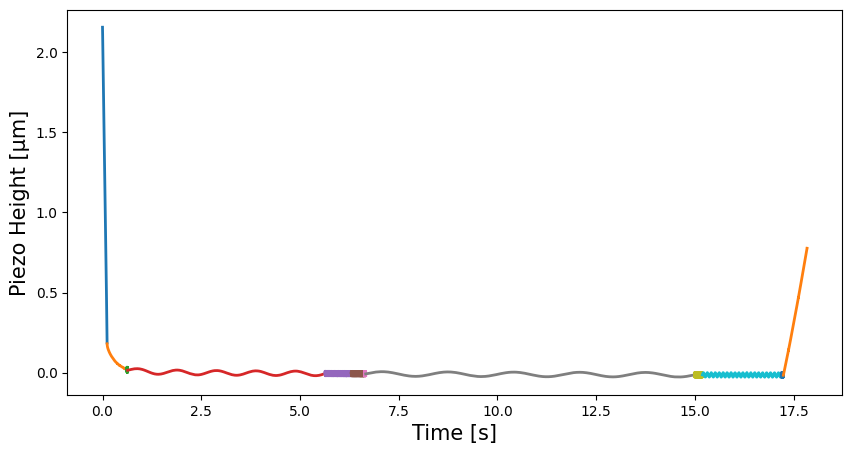

In [56]:
t0 = 0
lastval = 0
force_curve.preprocess_force_curve(deflection_sensitivity, height_channel)
force_curve_segments = force_curve.get_segments()
for seg_id, segment in force_curve_segments:
    if seg_id == 14:
        continue
    height = segment.zheight - 9.631827766268822e-06
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height * 1e6, linewidth=2,)
    t0 = time[-1]
    lastval = height[-1]
    
plt.xlabel("Time [s]", fontsize = 15)
plt.ylabel("Piezo Height [μm]", fontsize = 15)
# plt.grid()
plt.show()

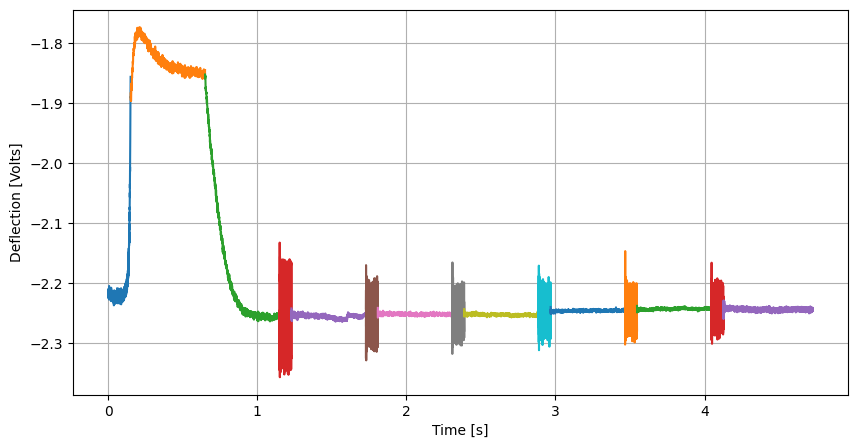

In [10]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

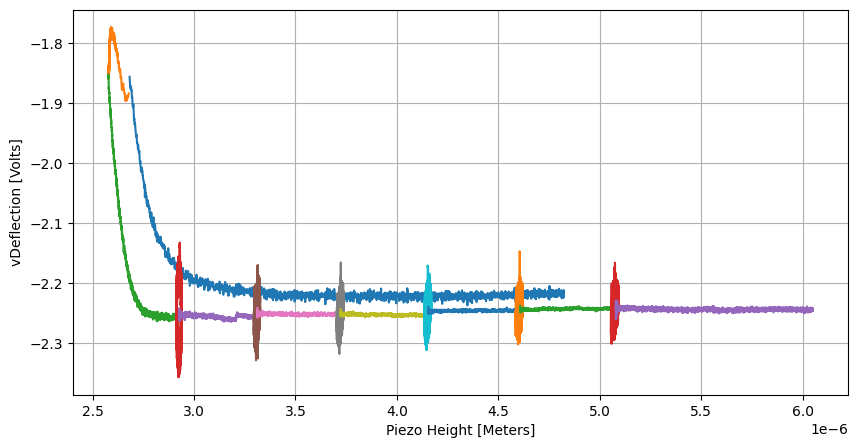

In [11]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [12]:
# Get distances from the sample, needed to compute Bh
x0 = 0
distances = []
sorted_ret_segments = sorted(retract_segments, key=lambda x: int(x[0]))
print(sorted_ret_segments)
for first_ret_seg_id, first_ret_seg in sorted_ret_segments[:-1]:
    distance_from_sample = -1 * first_ret_seg.segment_metadata['ramp_size'] + x0 # Negative
    distances.append(distance_from_sample * 1e-9)
    x0 = distance_from_sample

print(*distances)

[(2, <pyafmreader.utils.segment.Segment object at 0x126536350>), (4, <pyafmreader.utils.segment.Segment object at 0x126535ab0>), (6, <pyafmreader.utils.segment.Segment object at 0x126535630>), (8, <pyafmreader.utils.segment.Segment object at 0x1265360b0>), (10, <pyafmreader.utils.segment.Segment object at 0x126536e60>), (12, <pyafmreader.utils.segment.Segment object at 0x126535990>), (14, <pyafmreader.utils.segment.Segment object at 0x126537040>)]
5.000000000000001e-07 1.0000000000000002e-06 1.5e-06 2.0000000000000003e-06 2.5e-06 3e-06


In [13]:
def get_retract_ramp_sizes(force_curve):
    x0 = 0
    distances = []
    sorted_ret_segments = sorted(force_curve.retract_segments, key=lambda x: int(x[0]))
    print(sorted_ret_segments)
    for _, ret_seg in sorted_ret_segments[:-1]:
        # Maybe in the future do not use the ramp size from header and compute
        # ramp size as zmax - zmin?
        distance_from_sample = -1 * ret_seg.segment_metadata['ramp_size'] + x0 # Negative
        distances.append(distance_from_sample * 1e-9) # in nm
        x0 = distance_from_sample
    return distances

In [14]:
print(get_retract_ramp_sizes(force_curve))

[(2, <pyafmreader.utils.segment.Segment object at 0x126536350>), (4, <pyafmreader.utils.segment.Segment object at 0x126535ab0>), (6, <pyafmreader.utils.segment.Segment object at 0x126535630>), (8, <pyafmreader.utils.segment.Segment object at 0x1265360b0>), (10, <pyafmreader.utils.segment.Segment object at 0x126536e60>), (12, <pyafmreader.utils.segment.Segment object at 0x126535990>), (14, <pyafmreader.utils.segment.Segment object at 0x126537040>)]
[5.000000000000001e-07, 1.0000000000000002e-06, 1.5e-06, 2.0000000000000003e-06, 2.5e-06, 3e-06]


In [15]:
# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]
app_deflection, app_height, app_time =\
    preprocess_segment(first_ext_seg, height_channel, deflection_sensitivity)

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
ret_deflection, ret_height, ret_time =\
    preprocess_segment(last_ret_seg, height_channel, deflection_sensitivity)

if pause_segments:
    # Get first pause segment
    first_pause_seg_id, first_pause_seg = pause_segments[0]
    pau_deflection, pau_height, pau_time =\
        preprocess_segment(first_pause_seg, height_channel, deflection_sensitivity)

if modulation_segments:
    modulation_data = {}
    for seg_id, seg_data in modulation_segments:
        segment_data = {}
        mod_deflection, mod_height, mod_time =\
            preprocess_segment(seg_data, height_channel, deflection_sensitivity)
        segment_data['height'] = mod_height
        segment_data['deflection'] = mod_deflection
        segment_data['time'] = mod_time
        modulation_data[seg_id] = segment_data

NameError: name 'preprocess_segment' is not defined

In [ ]:
# Shift height
xzero = ret_height[-1] # Maximum height
app_height = xzero - app_height
ret_height = xzero - ret_height
if pause_segments:
    pau_height = xzero - pau_height
if modulation_segments:
    for segment_data in modulation_data.values():
        segment_data['height'] = xzero - segment_data['height']

In [ ]:
if modulation_segments:
    for segment_data in modulation_data.values():
        mod_indentation, mod_force =\
            get_force_vs_indentation_curve(segment_data['height'], segment_data['deflection'], [0,0], spring_constant)
        segment_data['indentation'] = mod_indentation
        segment_data['force'] = mod_force

In [ ]:
results = []

for seg_id, seg_data in modulation_segments:
    frequency = seg_data.segment_metadata["frequency"]
    # data = modulation_data[seg_id]
    # time = data['time']
    # indentation = data['indentation']
    # force = data['force']
    # deltat = time[1] - time[0]
    # fs = 1 / deltat
    # indentation, force, time =\
    #     detrend_rolling_average(frequency, indentation, force, time, 'indentation', 'force', [])
    #Bh, Hd, gamma2 = ComputeBh(force, indentation, fs, frequency, fi=18)
    #results.append((frequency, Bh, Hd, gamma2))
    results.append((seg_id, frequency))

results = sorted(results, key=lambda x: int(x[0]))
print(results)
frequencies_results = [x[0] for x in results]
Bh_results = [x[1] for x in results]
Hd_results = [x[2] for x in results]

In [ ]:
plt.plot(distances, np.imag(Hd_results), "r^-", label="Hd Imag")
plt.plot(distances, np.real(Hd_results), "bo-", label="Hd Real")
plt.xlabel("Distance [m]")
plt.ylabel("Hd")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(distances, Bh_results, "go-")
plt.xlabel("Bh")
plt.ylabel("Distance [m]")
plt.grid()
plt.show()